In [1]:
!nvidia-smi

Mon Jun 24 08:33:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [71]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
ROOT_PATH='/content/drive/MyDrive/content'

In [6]:
!pwd

/content


In [10]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/content'

In [11]:
!ls

train  validation


In [13]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/content/train'
valid_path = '/content/drive/MyDrive/content/validation'


In [14]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 2s 0us/step


In [15]:
# don't train existing weights
for layer in vgg16.layers:
  print(layer)

In [16]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [17]:
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/content/train/*')

In [20]:
folders

['/content/drive/MyDrive/content/train/Dog',
 '/content/drive/MyDrive/content/train/Cat']

In [21]:
len(folders)

2

In [22]:
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [23]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [24]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [25]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [26]:
!pwd

/content/drive/MyDrive/content


In [28]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/content/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 337 images belonging to 2 classes.


In [29]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/content/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 59 images belonging to 2 classes.


In [30]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
11/11 [==============================] - 141s 13s/step - loss: 4.2688 - accuracy: 0.5163 - val_loss: 0.3739 - val_accuracy: 0.8475
Epoch 2/10
11/11 [==============================] - 7s 653ms/step - loss: 0.4038 - accuracy: 0.8190 - val_loss: 0.3903 - val_accuracy: 0.8644
Epoch 3/10
11/11 [==============================] - 7s 624ms/step - loss: 0.2482 - accuracy: 0.8783 - val_loss: 0.3668 - val_accuracy: 0.8644
Epoch 4/10
11/11 [==============================] - 6s 515ms/step - loss: 0.2260 - accuracy: 0.9080 - val_loss: 0.3760 - val_accuracy: 0.8305
Epoch 5/10
11/11 [==============================] - 6s 580ms/step - loss: 0.1281 - accuracy: 0.9585 - val_loss: 0.3762 - val_accuracy: 0.8475
Epoch 6/10
11/11 [==============================] - 6s 500ms/step - loss: 0.0943 - accuracy: 0.9614 - val_loss: 0.4137 - val_accuracy: 0.8475
Epoch 7/10
11/11 [==============================] - 6s 504ms/step - loss: 0.0761 - accuracy: 0.9763 - val_loss: 0.3866 - val_accuracy: 0.8475
Epoch 

In [31]:
import matplotlib.pyplot as plt

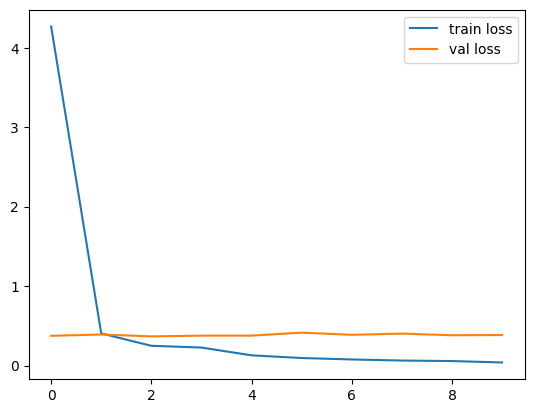

<Figure size 640x480 with 0 Axes>

In [32]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

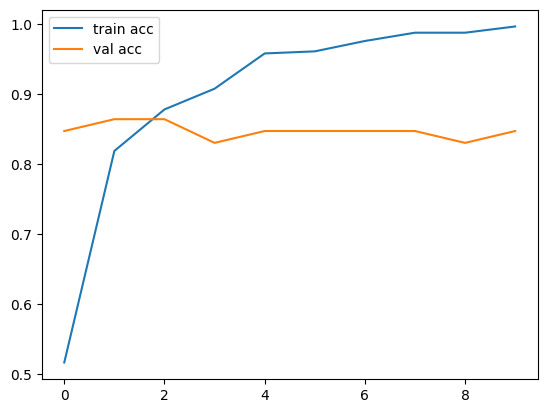

<Figure size 640x480 with 0 Axes>

In [33]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [34]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
y_pred = model.predict(test_set)

2/2 [==============================] - 0s 163ms/step


In [36]:
y_pred

array([[3.4481031e-01, 6.5518969e-01],
       [9.9835432e-01, 1.6457511e-03],
       [8.1828088e-01, 1.8171914e-01],
       [9.5176810e-01, 4.8231926e-02],
       [9.2477447e-01, 7.5225532e-02],
       [3.0875165e-04, 9.9969125e-01],
       [9.9498248e-01, 5.0174682e-03],
       [5.1041639e-01, 4.8958355e-01],
       [1.8465092e-02, 9.8153496e-01],
       [1.2695599e-01, 8.7304395e-01],
       [7.4472837e-03, 9.9255270e-01],
       [1.8216641e-01, 8.1783354e-01],
       [9.9875402e-01, 1.2460083e-03],
       [9.9948752e-01, 5.1249727e-04],
       [7.9167194e-06, 9.9999213e-01],
       [5.2253652e-02, 9.4774634e-01],
       [1.0552085e-03, 9.9894482e-01],
       [1.0866719e-01, 8.9133286e-01],
       [5.8416312e-04, 9.9941587e-01],
       [5.6513524e-01, 4.3486476e-01],
       [9.2883307e-01, 7.1166962e-02],
       [5.2840082e-10, 1.0000000e+00],
       [8.3863395e-01, 1.6136603e-01],
       [9.9950588e-01, 4.9411284e-04],
       [9.8701686e-01, 1.2983164e-02],
       [5.7615602e-05, 9.

In [37]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [38]:
y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [40]:
model=load_model('model_vgg16.h5')

In [43]:
img=image.load_img('/content/drive/MyDrive/content/cat.jgp.jpg',target_size=(224,224))

In [44]:
x=image.img_to_array(img)
x

array([[[220., 231., 235.],
        [220., 231., 235.],
        [220., 231., 235.],
        ...,
        [214., 223., 228.],
        [215., 224., 229.],
        [215., 224., 229.]],

       [[220., 231., 235.],
        [220., 231., 235.],
        [220., 231., 235.],
        ...,
        [214., 223., 228.],
        [214., 223., 228.],
        [214., 223., 228.]],

       [[220., 231., 235.],
        [220., 231., 235.],
        [221., 232., 236.],
        ...,
        [214., 223., 228.],
        [214., 223., 228.],
        [214., 223., 228.]],

       ...,

       [[207., 218., 224.],
        [207., 218., 224.],
        [207., 218., 224.],
        ...,
        [158., 160., 149.],
        [157., 160., 149.],
        [156., 159., 148.]],

       [[207., 218., 224.],
        [207., 218., 224.],
        [207., 218., 224.],
        ...,
        [159., 161., 150.],
        [157., 160., 149.],
        [157., 160., 149.]],

       [[208., 219., 225.],
        [208., 219., 225.],
        [208., 2

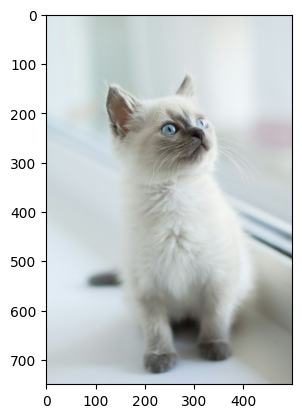

In [45]:
Z = plt.imread('/content/drive/MyDrive/content/cat.jgp.jpg')
plt.imshow(Z)

In [46]:
x.shape

(224, 224, 3)

In [47]:
x=x/255

In [48]:
from keras.applications.vgg16 import preprocess_input

In [49]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [50]:
model.predict(img_data)

1/1 [==============================] - 1s 1s/step


array([[0.98278934, 0.01721074]], dtype=float32)

In [51]:
result = np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 21ms/step


In [52]:
result[0]

0

In [53]:
if result[0] == 1:
    prediction = 'dog'
    print(prediction)
else:
    prediction = 'cat'
    print(prediction)

cat
